In [5]:
import pandas as pd
import numpy as np
import re
from ast import literal_eval

# Load dataset
df = pd.read_csv("Data/borg_traces_data.csv")
print("✅ Dataset loaded:", df.shape)

# Fix parsing of CPU histograms
def parse_hist(x):
    try:
        if isinstance(x, str):
            x_clean = re.sub(r"\s+", ",", x.strip())
            arr = np.array(literal_eval(x_clean), dtype=np.float32)
            return arr if arr.shape[0] == 11 else None  # Match 11-bin sequences
    except:
        return None
    return None

df["cpu_hist"] = df["cpu_usage_distribution"].apply(parse_hist)

# Clean subset with histograms, time, and healthy label
df_clean = df.dropna(subset=["cpu_hist", "time", "machine_id", "failed"])
df_clean["failed"] = df_clean["failed"].astype(int)

print(f"✅ Parsed histograms using regex. Valid rows: {len(df_clean)}")
print("Example parsed histogram (first 10 bins):", df_clean["cpu_hist"].iloc[0][:10])


✅ Dataset loaded: (405894, 34)
✅ Parsed histograms using regex. Valid rows: 390219
Example parsed histogram (first 10 bins): [0.00314331 0.00381088 0.00401306 0.00415039 0.00432587 0.00449371
 0.00463104 0.00478363 0.00498962 0.00530243]


C:\Users\binwa\AppData\Local\Temp\ipykernel_19640\3909176530.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["failed"] = df_clean["failed"].astype(int)


In [6]:
from collections import Counter

# Parameters
seq_len = 6
X_seq = []
invalid_count = 0

# Group by machine_id to preserve temporal structure
for mid, group in df_clean[df_clean["failed"] == 0].groupby("machine_id"):
    group = group.sort_values(by="time")
    hists = group["cpu_hist"].tolist()

    for i in range(len(hists) - seq_len + 1):
        seq = hists[i:i + seq_len]
        if all(len(vec) == 11 for vec in seq):  # ✅ Only accept clean 11-bin histograms
            X_seq.append(np.stack(seq))
        else:
            invalid_count += 1

print(f"✅ Valid sequences: {len(X_seq)}")
print(f"❌ Invalid sequences (bad shapes): {invalid_count}")


✅ Valid sequences: 146
❌ Invalid sequences (bad shapes): 0


In [7]:
import numpy as np

# Convert list of sequences to NumPy array
X_seq = np.stack(X_seq)  # shape: (num_sequences, 6, 11)

# Flatten sequences into shape (num_sequences, 66) for input to Autoencoder
X_seq_flat = X_seq.reshape(X_seq.shape[0], -1)

print(f"📦 Input sequence tensor shape (N, 6, 11): {X_seq.shape}")
print(f"📐 Flattened input shape for Autoencoder: {X_seq_flat.shape}")


📦 Input sequence tensor shape (N, 6, 11): (146, 6, 11)
📐 Flattened input shape for Autoencoder: (146, 66)


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensor
X_tensor = torch.tensor(X_seq_flat, dtype=torch.float32)

# Define Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim=66, hidden_dim=32, bottleneck_dim=8):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiate model
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train on healthy data
batch_size = 256
loader = DataLoader(X_tensor, batch_size=batch_size, shuffle=True)

# Training loop
n_epochs = 30
model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        reconstructed = model(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {epoch_loss:.4f}")


Epoch 1/30 - Loss: 0.0213
Epoch 2/30 - Loss: 0.0200
Epoch 3/30 - Loss: 0.0189
Epoch 4/30 - Loss: 0.0177
Epoch 5/30 - Loss: 0.0167
Epoch 6/30 - Loss: 0.0156
Epoch 7/30 - Loss: 0.0147
Epoch 8/30 - Loss: 0.0138
Epoch 9/30 - Loss: 0.0129
Epoch 10/30 - Loss: 0.0121
Epoch 11/30 - Loss: 0.0113
Epoch 12/30 - Loss: 0.0106
Epoch 13/30 - Loss: 0.0099
Epoch 14/30 - Loss: 0.0092
Epoch 15/30 - Loss: 0.0086
Epoch 16/30 - Loss: 0.0080
Epoch 17/30 - Loss: 0.0075
Epoch 18/30 - Loss: 0.0070
Epoch 19/30 - Loss: 0.0065
Epoch 20/30 - Loss: 0.0060
Epoch 21/30 - Loss: 0.0056
Epoch 22/30 - Loss: 0.0052
Epoch 23/30 - Loss: 0.0048
Epoch 24/30 - Loss: 0.0045
Epoch 25/30 - Loss: 0.0041
Epoch 26/30 - Loss: 0.0038
Epoch 27/30 - Loss: 0.0035
Epoch 28/30 - Loss: 0.0033
Epoch 29/30 - Loss: 0.0030
Epoch 30/30 - Loss: 0.0028


In [9]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, roc_auc_score

# Switch model to evaluation mode and encode all training points
model.eval()
with torch.no_grad():
    embeddings = model.encoder(X_tensor).numpy()  # Shape: (N, bottleneck_dim)

print("✅ Encoded embeddings shape:", embeddings.shape)

# Fit One-Class SVM on healthy embeddings
svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)
svm.fit(embeddings)

# Predict anomalies: -1 = anomaly, 1 = normal
y_pred_svm = svm.predict(embeddings)
y_pred_labels = (y_pred_svm == -1).astype(int)  # 1 = anomaly, 0 = normal

# Since we trained only on healthy data, all should be normal
true_labels = np.zeros_like(y_pred_labels)

# Evaluate performance
print("\n📊 One-Class SVM Self-Test Report (on healthy data only):")
print(classification_report(true_labels, y_pred_labels, target_names=["Normal", "Anomaly"]))


✅ Encoded embeddings shape: (146, 8)

📊 One-Class SVM Self-Test Report (on healthy data only):
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00       146
     Anomaly       0.00      0.00      0.00         0

    accuracy                           0.99       146
   macro avg       0.50      0.50      0.50       146
weighted avg       1.00      0.99      1.00       146



c:\Users\binwa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\binwa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\binwa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
# Collect test sequences with both failed and healthy labels
X_real_seq = []
real_labels = []

for mid, group in df.groupby("machine_id"):
    group = group.sort_values(by="time")
    hists = group["cpu_hist"].tolist()
    labels = group["failed"].tolist()

    for i in range(len(hists) - seq_len + 1):
        seq = hists[i:i+seq_len]
        if all(isinstance(vec, np.ndarray) and len(vec) == 11 for vec in seq):
            X_real_seq.append(np.stack(seq))  # shape: (6, 11)
            real_labels.append(labels[i + seq_len - 1])

print(f"✅ Real sequences collected: {len(X_real_seq)}")


✅ Real sequences collected: 5565



📋 Classification Report (One-Class SVM on real data):
              precision    recall  f1-score   support

      Normal       0.90      1.00      0.94      4985
        Fail       0.04      0.00      0.00       580

    accuracy                           0.89      5565
   macro avg       0.47      0.50      0.47      5565
weighted avg       0.81      0.89      0.84      5565

🔥 ROC AUC Score: 0.499


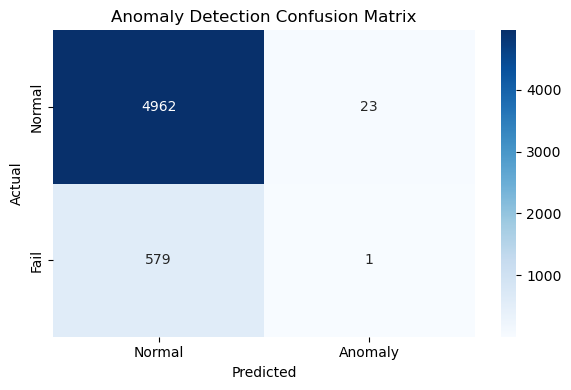

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Flatten the real sequences
X_real_seq = np.stack(X_real_seq)  # shape: (N, 6, 11)
X_real_flat = X_real_seq.reshape(X_real_seq.shape[0], -1)
X_real_tensor = torch.tensor(X_real_flat, dtype=torch.float32)

# Get latent features from encoder
model.eval()
with torch.no_grad():
    latent_real = model.encoder(X_real_tensor).numpy()

# Predict anomalies with SVM
y_pred_real = (svm.predict(latent_real) == -1).astype(int)  # 1 = anomaly
y_true_real = np.array(real_labels)                         # 1 = failure

# 📊 Evaluation
print("\n📋 Classification Report (One-Class SVM on real data):")
print(classification_report(y_true_real, y_pred_real, target_names=["Normal", "Fail"]))

roc_score = roc_auc_score(y_true_real, y_pred_real)
print(f"🔥 ROC AUC Score: {roc_score:.3f}")

# 🔍 Confusion Matrix
cm = confusion_matrix(y_true_real, y_pred_real)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Fail"])
plt.title("Anomaly Detection Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
os.makedirs("visualization", exist_ok=True)
plt.savefig("visualization/one_class_svm_confusion_matrix.png")
plt.show()


🔍 Showing explanation for anomaly index 313 (true label = 0)


C:\Users\binwa\AppData\Local\Temp\ipykernel_19640\3432794707.py:17: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\binwa\AppData\Local\Temp\ipykernel_19640\3432794707.py:18: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.savefig("visualization/autoencoder_error_heatmap_sample.png")
c:\Users\binwa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


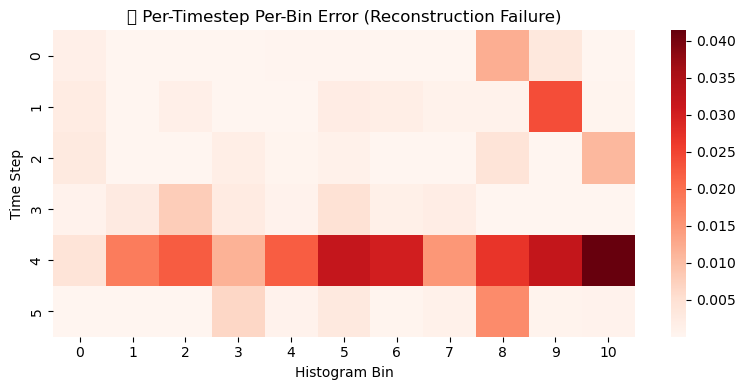

In [16]:
# Compute per-feature squared error
errors = (X_real_flat - X_reconstructed)**2  # shape: (N, 66)

# Choose one anomalous sample (detected as anomaly)
anomalous_indices = np.where(y_pred_real == 1)[0]
if len(anomalous_indices) > 0:
    idx = anomalous_indices[0]
    print(f"🔍 Showing explanation for anomaly index {idx} (true label = {y_true_real[idx]})")

    error_vector = errors[idx].reshape(seq_len, -1)  # shape: (6, 11)

    plt.figure(figsize=(8, 4))
    sns.heatmap(error_vector, cmap="Reds", annot=False, cbar=True)
    plt.title("🔍 Per-Timestep Per-Bin Error (Reconstruction Failure)")
    plt.xlabel("Histogram Bin")
    plt.ylabel("Time Step")
    plt.tight_layout()
    plt.savefig("visualization/autoencoder_error_heatmap_sample.png")
    plt.show()
else:
    print("❌ No detected anomalies to explain.")
